In [ ]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers imbalanced-learn seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
# IMPORTANT: Keep the topic as a list, not just the first element
df['topic_list'] = df['topic'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [])
df = df[['text', 'topic_list']]
df = df[df['text'] != '']
df = df[df['topic_list'].apply(len) > 0] # Ensure every row has at least one topic

print("--- Data Loading and Preparation ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: MultiLabelBinarizer for multi-label classification
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df['topic_list'])
num_labels = len(mlb.classes_)
print(f"Found {num_labels} unique topics.")

# Step 5: Train/Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], labels, test_size=0.2, random_state=42
)

# Step 6: Create PyTorch Datasets
class MultiLabelTopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        # Only call .clone().detach() if it's a tensor; for IDs it's unnecessary
        item = {key: val[idx].clone().detach() if torch.is_tensor(val[idx]) else val[idx]
                for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item
    def __len__(self):
        return len(self.labels)

# Tokenizers
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

train_encodings_db = tokenize(train_texts, distilbert_tokenizer)
val_encodings_db = tokenize(val_texts, distilbert_tokenizer)
train_encodings_rb = tokenize(train_texts, roberta_tokenizer)
val_encodings_rb = tokenize(val_texts, roberta_tokenizer)

train_dataset_db = MultiLabelTopicDataset(train_encodings_db, train_labels)
val_dataset_db = MultiLabelTopicDataset(val_encodings_db, val_labels)
train_dataset_rb = MultiLabelTopicDataset(train_encodings_rb, train_labels)
val_dataset_rb = MultiLabelTopicDataset(val_encodings_rb, val_labels)

# --- Train Model 1: DistilBERT ---
print("--- Training DistilBERT for Multi-Label Classification ---")
model_db = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels, problem_type="multi_label_classification")
training_args = TrainingArguments(output_dir='./ensemble_multi/distilbert_preprocessed', num_train_epochs=15, per_device_train_batch_size=8, report_to=[])
trainer_db = Trainer(model=model_db, args=training_args, train_dataset=train_dataset_db)
trainer_db.train()

# --- Train Model 2: RoBERTa ---
print("\n--- Training RoBERTa for Multi-Label Classification ---")
model_rb = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels, problem_type="multi_label_classification")
training_args_rb = TrainingArguments(output_dir='./ensemble_multi/roberta_preprocessed', num_train_epochs=15, per_device_train_batch_size=8, report_to=[])
trainer_rb = Trainer(model=model_rb, args=training_args_rb, train_dataset=train_dataset_rb)
trainer_rb.train()
print("\n" + "="*50 + "\n")

# --- Step 7: Get Ensemble Predictions ---
print("--- Generating Ensemble Predictions ---")
preds_db = trainer_db.predict(val_dataset_db)
preds_rb = trainer_rb.predict(val_dataset_rb)
logits_db = torch.from_numpy(preds_db.predictions)
logits_rb = torch.from_numpy(preds_rb.predictions)
avg_logits = (logits_db + logits_rb) / 2
sigmoid = torch.nn.Sigmoid()
avg_probs = sigmoid(avg_logits).numpy()
y_true = val_labels
print("Prediction generation complete.")
print("\n" + "="*50 + "\n")

# --- Step 8: Find the Optimal Threshold ---
print("--- Finding Optimal Prediction Threshold ---")
best_f1 = 0
optimal_threshold = 0.5
for threshold in np.arange(0.1, 0.9, 0.05):
    y_pred_temp = (avg_probs > threshold).astype(int)
    f1_micro = f1_score(y_true, y_pred_temp, average='micro', zero_division=0)
    print(f"Threshold: {threshold:.2f}, F1 (micro): {f1_micro:.4f}")
    if f1_micro > best_f1:
        best_f1 = f1_micro
        optimal_threshold = threshold

print(f"\nOptimal Threshold found: {optimal_threshold:.2f} with F1-Micro Score: {best_f1:.4f}")
print("\n" + "="*50 + "\n")

# --- Step 9: Evaluate with Optimal Threshold ---
print("--- Evaluating Hybrid Model with Optimal Threshold ---")
y_pred_ensemble = (avg_probs > optimal_threshold).astype(int)

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=mlb.classes_, zero_division=0))
print("\n" + "="*50 + "\n")

# --- Step 10: Inference with Ensemble and Optimal Threshold ---
print("--- Hybrid Model Inference Example ---")
test_text = "organ choos concern eye stage three point despit senior serv citizen idea u"
inputs_db = tokenize([test_text], distilbert_tokenizer)
inputs_rb = tokenize([test_text], roberta_tokenizer)

# Use correct device ('cuda' if available, else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_db.to(device)
model_rb.to(device)
inputs_db = {k: v.to(device) for k, v in inputs_db.items()}
inputs_rb = {k: v.to(device) for k, v in inputs_rb.items()}

model_db.eval()
model_rb.eval()
with torch.no_grad():
    logits_db = model_db(**inputs_db).logits
    logits_rb = model_rb(**inputs_rb).logits
    avg_logits_inf = (logits_db + logits_rb) / 2
    probs_inf = torch.sigmoid(avg_logits_inf)
    # Apply the optimal threshold found earlier
    pred_labels_bin = (probs_inf > optimal_threshold).cpu().numpy()
    pred_topics = mlb.inverse_transform(pred_labels_bin)
    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topics: {pred_topics[0]}")

--- Data Loading and Preparation ---
Data shape after processing: (200, 2)


Found 30 unique topics.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Training DistilBERT for Multi-Label Classification ---


Step,Training Loss


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Training RoBERTa for Multi-Label Classification ---


Step,Training Loss




--- Generating Ensemble Predictions ---


Prediction generation complete.


--- Finding Optimal Prediction Threshold ---
Threshold: 0.10, F1 (micro): 0.1000
Threshold: 0.15, F1 (micro): 0.0299
Threshold: 0.20, F1 (micro): 0.0000
Threshold: 0.25, F1 (micro): 0.0000
Threshold: 0.30, F1 (micro): 0.0000
Threshold: 0.35, F1 (micro): 0.0000
Threshold: 0.40, F1 (micro): 0.0000
Threshold: 0.45, F1 (micro): 0.0000
Threshold: 0.50, F1 (micro): 0.0000
Threshold: 0.55, F1 (micro): 0.0000
Threshold: 0.60, F1 (micro): 0.0000
Threshold: 0.65, F1 (micro): 0.0000
Threshold: 0.70, F1 (micro): 0.0000
Threshold: 0.75, F1 (micro): 0.0000
Threshold: 0.80, F1 (micro): 0.0000
Threshold: 0.85, F1 (micro): 0.0000

Optimal Threshold found: 0.10 with F1-Micro Score: 0.1000


--- Evaluating Hybrid Model with Optimal Threshold ---

Hybrid Model Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (200, 2)


--- Training DistilBERT Model ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,3.011600
40,2.996400
60,2.980500
80,2.928600
100,2.887700
120,2.785500
140,2.701400
160,2.568500
180,2.512700
200,2.436500


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Training RoBERTa Model ---


Step,Training Loss
20,2.997600
40,3.017600
60,3.011500
80,3.000300
100,3.005700
120,2.994700
140,2.946600
160,2.893500
180,2.823200
200,2.766500




--- Evaluating Ensemble Model ---



Ensemble Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       0.00      0.00      0.00         3
          climat       0.40      0.67      0.50         3
      cybersecur       1.00      0.33      0.50         3
            data       0.20      0.33      0.25         3
           digit       0.00      0.00      0.00         3
            educ       0.25      0.33      0.29         3
entrepreneurship       0.00      0.00      0.00         3
     environment       1.00      0.33      0.50         3
          health       0.29      0.67      0.40         3
         histori       0.50      1.00      0.67         3
          machin       0.50      0.33      0.40         3
          person       0.00      0.00      0.00         3
       psycholog       1.00      0.67      0.80         3
         quantum       0.25      0.50

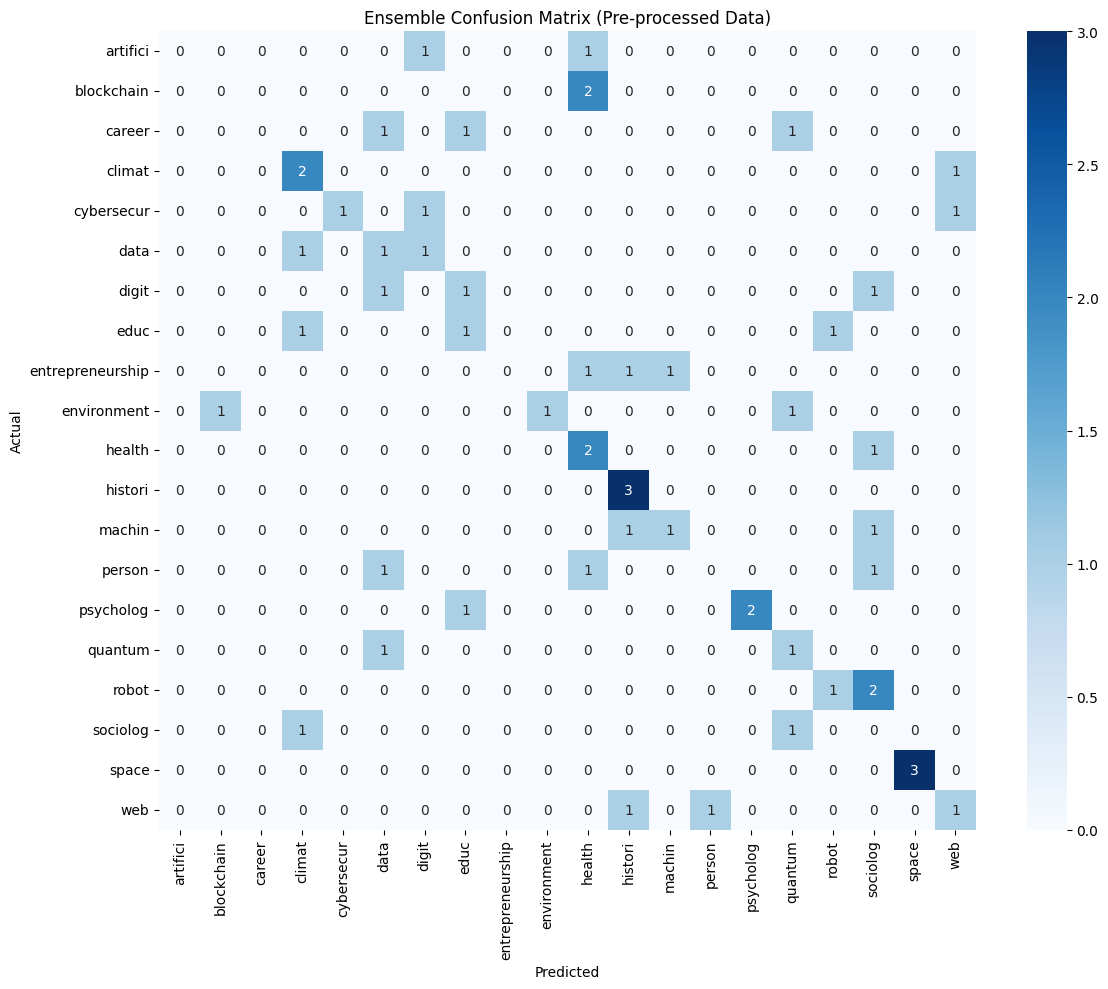

In [ ]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else '')
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

# Step 5: Handle Class Imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
X_resampled = X_resampled.flatten()
df_balanced = pd.DataFrame({'text': X_resampled, 'label': y_resampled})

# Step 6: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)

# Step 7: Create PyTorch Datasets for both models
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Tokenizers
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

train_encodings_db = tokenize(train_df['text'], distilbert_tokenizer)
val_encodings_db = tokenize(val_df['text'], distilbert_tokenizer)
train_encodings_rb = tokenize(train_df['text'], roberta_tokenizer)
val_encodings_rb = tokenize(val_df['text'], roberta_tokenizer)

train_dataset_db = TopicDataset(train_encodings_db, train_df['label'].values)
val_dataset_db = TopicDataset(val_encodings_db, val_df['label'].values)
train_dataset_rb = TopicDataset(train_encodings_rb, train_df['label'].values)
val_dataset_rb = TopicDataset(val_encodings_rb, val_df['label'].values)

# --- Train Model 1: DistilBERT ---
print("--- Training DistilBERT Model ---")
model_db = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
training_args_db = TrainingArguments(
    output_dir='./ensemble/distilbert_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_db = Trainer(model=model_db, args=training_args_db, train_dataset=train_dataset_db)
trainer_db.train()

# --- Train Model 2: RoBERTa ---
print("\n--- Training RoBERTa Model ---")
model_rb = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
training_args_rb = TrainingArguments(
    output_dir='./ensemble/roberta_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_rb = Trainer(model=model_rb, args=training_args_rb, train_dataset=train_dataset_rb)
trainer_rb.train()
print("\n" + "="*50 + "\n")

# --- Step 8: Ensemble Predictions and Evaluate ---
print("--- Evaluating Ensemble Model ---")
preds_db = trainer_db.predict(val_dataset_db)
preds_rb = trainer_rb.predict(val_dataset_rb)

probs_db = torch.softmax(torch.from_numpy(preds_db.predictions), dim=1).numpy()
probs_rb = torch.softmax(torch.from_numpy(preds_rb.predictions), dim=1).numpy()
avg_probs = (probs_db + probs_rb) / 2

y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_df['label'].values

print("\nEnsemble Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Ensemble Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_ensemble_preprocessed.png")
print("Ensemble confusion matrix saved as confusion_matrix_ensemble_preprocessed.png")
print("\n" + "="*50 + "\n")

# --- Step 9: Inference with Ensemble ---
print("--- Ensemble Inference Example ---")
test_text = "marriag best film dream wish"

inputs_db = tokenize([test_text], distilbert_tokenizer)
inputs_rb = tokenize([test_text], roberta_tokenizer)

device = trainer_db.args.device
inputs_db = {k: v.to(device) for k, v in inputs_db.items()}
inputs_rb = {k: v.to(device) for k, v in inputs_rb.items()}

model_db.eval()
model_rb.eval()
with torch.no_grad():
    logits_db = model_db(**inputs_db).logits
    logits_rb = model_rb(**inputs_rb).logits

    probs_db_inf = torch.softmax(logits_db, dim=1)
    probs_rb_inf = torch.softmax(logits_rb, dim=1)

    avg_probs_inf = (probs_db_inf + probs_rb_inf) / 2

    pred_label = avg_probs_inf.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]

    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")

**Distil + Albert**

In [ ]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    AlbertTokenizer, AlbertForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()

# Keep the topic as a list for multi-label classification
df['topic_list'] = df['topic'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [])
df = df[['text', 'topic_list']]
df = df[df['text'] != '']
df = df[df['topic_list'].apply(len) > 0] # Ensure every row has at least one topic

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Multi-Label Binarization
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df['topic_list'])
num_labels = len(mlb.classes_)
print(f"Found {num_labels} unique topics.")

# Step 5: Train/Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], labels, test_size=0.2, random_state=42
)

# Step 6: Create PyTorch Datasets
class MultiLabelTopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        # Labels must be float for multi-label loss function
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item
    def __len__(self):
        return len(self.labels)

# Tokenizers
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

# Create datasets for each model
train_encodings_db = tokenize(train_texts, distilbert_tokenizer)
val_encodings_db = tokenize(val_texts, distilbert_tokenizer)
train_encodings_albert = tokenize(train_texts, albert_tokenizer)
val_encodings_albert = tokenize(val_texts, albert_tokenizer)

train_dataset_db = MultiLabelTopicDataset(train_encodings_db, train_labels)
val_dataset_db = MultiLabelTopicDataset(val_encodings_db, val_labels)
train_dataset_albert = MultiLabelTopicDataset(train_encodings_albert, train_labels)
val_dataset_albert = MultiLabelTopicDataset(val_encodings_albert, val_labels)

# --- Train Model 1: DistilBERT ---
print("--- Training DistilBERT for Multi-Label Classification ---")
model_db = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels, problem_type="multi_label_classification")
training_args_db = TrainingArguments(output_dir='./ensemble_multi/distilbert_preprocessed', num_train_epochs=15, per_device_train_batch_size=8, report_to=[])
trainer_db = Trainer(model=model_db, args=training_args_db, train_dataset=train_dataset_db)
trainer_db.train()

# --- Train Model 2: ALBERT ---
print("\n--- Training ALBERT for Multi-Label Classification ---")
model_albert = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=num_labels, problem_type="multi_label_classification")
training_args_albert = TrainingArguments(output_dir='./ensemble_multi/albert_preprocessed', num_train_epochs=15, per_device_train_batch_size=8, report_to=[])
trainer_albert = Trainer(model=model_albert, args=training_args_albert, train_dataset=train_dataset_albert)
trainer_albert.train()
print("\n" + "="*50 + "\n")

# --- Step 7: Ensemble Predictions and Find Optimal Threshold ---
print("--- Evaluating Hybrid (DistilBERT + ALBERT) Model ---")
preds_db = trainer_db.predict(val_dataset_db)
preds_albert = trainer_albert.predict(val_dataset_albert)

# Get logits and average them
logits_db = torch.from_numpy(preds_db.predictions)
logits_albert = torch.from_numpy(preds_albert.predictions)
avg_logits = (logits_db + logits_albert) / 2

# Apply sigmoid to get probabilities
sigmoid = torch.nn.Sigmoid()
avg_probs = sigmoid(avg_logits).numpy()
y_true = val_labels

# Find the best threshold
best_f1 = 0
optimal_threshold = 0.5
print("--- Finding Optimal Prediction Threshold ---")
for threshold in np.arange(0.1, 0.9, 0.05):
    y_pred_temp = (avg_probs > threshold).astype(int)
    f1_micro = f1_score(y_true, y_pred_temp, average='micro', zero_division=0)
    print(f"Threshold: {threshold:.2f}, F1 (micro): {f1_micro:.4f}")
    if f1_micro > best_f1:
        best_f1 = f1_micro
        optimal_threshold = threshold
print(f"\nOptimal Threshold found: {optimal_threshold:.2f} with F1-Micro Score: {best_f1:.4f}")
print("\n" + "="*50 + "\n")

# --- Step 8: Evaluate with Optimal Threshold ---
y_pred_ensemble = (avg_probs > optimal_threshold).astype(int)
print("\nHybrid Model Classification Report (using optimal threshold):\n", classification_report(y_true, y_pred_ensemble, target_names=mlb.classes_, zero_division=0))

# --- Step 9: Inference with Hybrid Model ---
print("--- Hybrid Model Inference Example ---")
test_text = "organ choos concern eye stage three point despit senior serv citizen idea u"

inputs_db = tokenize([test_text], distilbert_tokenizer)
inputs_albert = tokenize([test_text], albert_tokenizer)

device = trainer_db.args.device
inputs_db = {k: v.to(device) for k, v in inputs_db.items()}
inputs_albert = {k: v.to(device) for k, v in inputs_albert.items()}

model_db.eval()
model_albert.eval()
with torch.no_grad():
    logits_db = model_db(**inputs_db).logits
    logits_albert = model_albert(**inputs_albert).logits

    avg_logits_inf = (logits_db + logits_albert) / 2
    probs_inf = torch.sigmoid(avg_logits_inf)

    # Apply the optimal threshold found earlier
    pred_labels_bin = (probs_inf > optimal_threshold).cpu().numpy()
    pred_topics = mlb.inverse_transform(pred_labels_bin)

    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topics: {pred_topics[0]}")

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (200, 2)


Found 30 unique topics.
--- Training DistilBERT for Multi-Label Classification ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Training ALBERT for Multi-Label Classification ---


Step,Training Loss




--- Evaluating Hybrid (DistilBERT + ALBERT) Model ---


--- Finding Optimal Prediction Threshold ---
Threshold: 0.10, F1 (micro): 0.0952
Threshold: 0.15, F1 (micro): 0.0000
Threshold: 0.20, F1 (micro): 0.0000
Threshold: 0.25, F1 (micro): 0.0000
Threshold: 0.30, F1 (micro): 0.0000
Threshold: 0.35, F1 (micro): 0.0000
Threshold: 0.40, F1 (micro): 0.0000
Threshold: 0.45, F1 (micro): 0.0000
Threshold: 0.50, F1 (micro): 0.0000
Threshold: 0.55, F1 (micro): 0.0000
Threshold: 0.60, F1 (micro): 0.0000
Threshold: 0.65, F1 (micro): 0.0000
Threshold: 0.70, F1 (micro): 0.0000
Threshold: 0.75, F1 (micro): 0.0000
Threshold: 0.80, F1 (micro): 0.0000
Threshold: 0.85, F1 (micro): 0.0000

Optimal Threshold found: 0.10 with F1-Micro Score: 0.0952



Hybrid Model Classification Report (using optimal threshold):
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       0.00      0.00      0.00         0
           chang     

--- Data Loading (from output_part_1.csv) ---
Data shape after processing: (200, 2)




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Training DistilBERT Model ---


Step,Training Loss
20,3.011600
40,2.997100
60,2.980600
80,2.926300
100,2.884000
120,2.773400
140,2.681800
160,2.540000
180,2.473700
200,2.383400


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Training ALBERT Model ---


Step,Training Loss
20,3.097600
40,2.990100
60,2.918200
80,2.770900
100,2.592300
120,2.342900
140,2.138400
160,1.969000
180,1.896500
200,1.699800




--- Evaluating Hybrid (Ensemble) Model ---



Hybrid Model Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       0.00      0.00      0.00         3
          climat       0.40      0.67      0.50         3
      cybersecur       1.00      0.33      0.50         3
            data       0.33      0.33      0.33         3
           digit       0.00      0.00      0.00         3
            educ       1.00      0.67      0.80         3
entrepreneurship       1.00      0.33      0.50         3
     environment       0.50      0.67      0.57         3
          health       1.00      0.67      0.80         3
         histori       0.75      1.00      0.86         3
          machin       0.67      0.67      0.67         3
          person       0.00      0.00      0.00         3
       psycholog       0.67      0.67      0.67         3
         quantum       0.67      

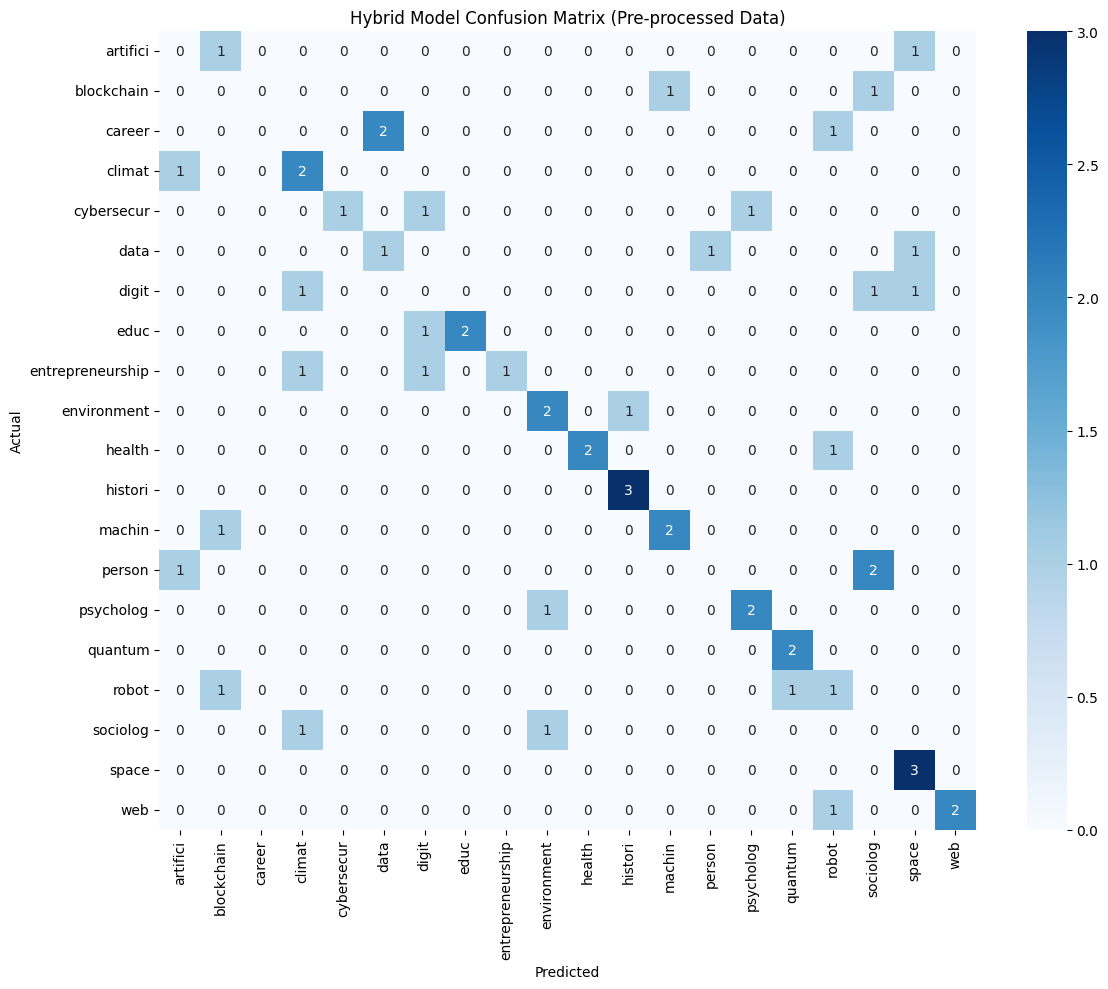

In [ ]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    AlbertTokenizer, AlbertForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') and len(ast.literal_eval(x)) > 0 else None)
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

# Step 5: Handle Class Imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
df_balanced = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Step 6: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)

# Step 7: Create PyTorch Datasets
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)

# Tokenizers
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

train_encodings_db = tokenize(train_df['text'], distilbert_tokenizer)
val_encodings_db = tokenize(val_df['text'], distilbert_tokenizer)
train_encodings_albert = tokenize(train_df['text'], albert_tokenizer)
val_encodings_albert = tokenize(val_df['text'], albert_tokenizer)

train_dataset_db = TopicDataset(train_encodings_db, train_df['label'].values)
val_dataset_db = TopicDataset(val_encodings_db, val_df['label'].values)
train_dataset_albert = TopicDataset(train_encodings_albert, train_df['label'].values)
val_dataset_albert = TopicDataset(val_encodings_albert, val_df['label'].values)

# --- Train Model 1: DistilBERT ---
print("--- Training DistilBERT Model ---")
model_db = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
training_args_db = TrainingArguments(
    output_dir='./ensemble/distilbert_preprocessed', num_train_epochs=15, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_db = Trainer(model=model_db, args=training_args_db, train_dataset=train_dataset_db)
trainer_db.train()

# --- Train Model 2: ALBERT ---
print("\n--- Training ALBERT Model ---")
model_albert = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=num_labels)
training_args_albert = TrainingArguments(
    output_dir='./ensemble/albert_preprocessed', num_train_epochs=15, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_albert = Trainer(model=model_albert, args=training_args_albert, train_dataset=train_dataset_albert)
trainer_albert.train()
print("\n" + "="*50 + "\n")

# --- Step 8: Ensemble Predictions and Evaluate ---
print("--- Evaluating Hybrid (Ensemble) Model ---")
preds_db = trainer_db.predict(val_dataset_db)
preds_albert = trainer_albert.predict(val_dataset_albert)

# Convert logits to probabilities using softmax and average them
probs_db = torch.softmax(torch.from_numpy(preds_db.predictions), dim=1).numpy()
probs_albert = torch.softmax(torch.from_numpy(preds_albert.predictions), dim=1).numpy()
avg_probs = (probs_db + probs_albert) / 2

# Use argmax to get the single best prediction from the averaged probabilities
y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_df['label'].values

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Hybrid Model Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_hybrid_preprocessed.png")
print("Hybrid confusion matrix saved as confusion_matrix_hybrid_preprocessed.png")
print("\n" + "="*50 + "\n")

# --- Step 9: Inference with Hybrid Model ---
print("--- Hybrid Model Inference Example ---")
test_text = "marriag best film dream wish"

inputs_db = tokenize([test_text], distilbert_tokenizer)
inputs_albert = tokenize([test_text], albert_tokenizer)

device = trainer_db.args.device
inputs_db = {k: v.to(device) for k, v in inputs_db.items()}
inputs_albert = {k: v.to(device) for k, v in inputs_albert.items()}

model_db.eval()
model_albert.eval()
with torch.no_grad():
    logits_db = model_db(**inputs_db).logits
    logits_albert = model_albert(**inputs_albert).logits

    probs_db_inf = torch.softmax(logits_db, dim=1)
    probs_albert = torch.softmax(logits_albert, dim=1)

    avg_probs_inf = (probs_db_inf + probs_albert) / 2

    pred_label = avg_probs_inf.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]

    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")

**Distill + MobileBert**

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (200, 2)




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Training DistilBERT Model ---


Step,Training Loss
20,3.007900
40,3.002100
60,2.986200
80,2.930900
100,2.886000
120,2.793000
140,2.710700
160,2.587200
180,2.531300
200,2.477200



--- Training MobileBERT Model ---


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,5773814.000000
40,38795.118800
60,3.459200
80,3.135000
100,2.962100
120,2.921600
140,2.701800
160,2.579200
180,2.567700
200,2.378500




--- Evaluating Hybrid (DistilBERT + MobileBERT) Model ---



Hybrid Model Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       0.33      0.33      0.33         3
          climat       0.33      0.67      0.44         3
      cybersecur       0.50      0.33      0.40         3
            data       0.25      0.33      0.29         3
           digit       0.00      0.00      0.00         3
            educ       0.50      0.67      0.57         3
entrepreneurship       0.00      0.00      0.00         3
     environment       0.50      0.33      0.40         3
          health       1.00      0.67      0.80         3
         histori       0.75      1.00      0.86         3
          machin       0.22      0.67      0.33         3
          person       0.00      0.00      0.00         3
       psycholog       0.40      0.67      0.50         3
         quantum       0.00      

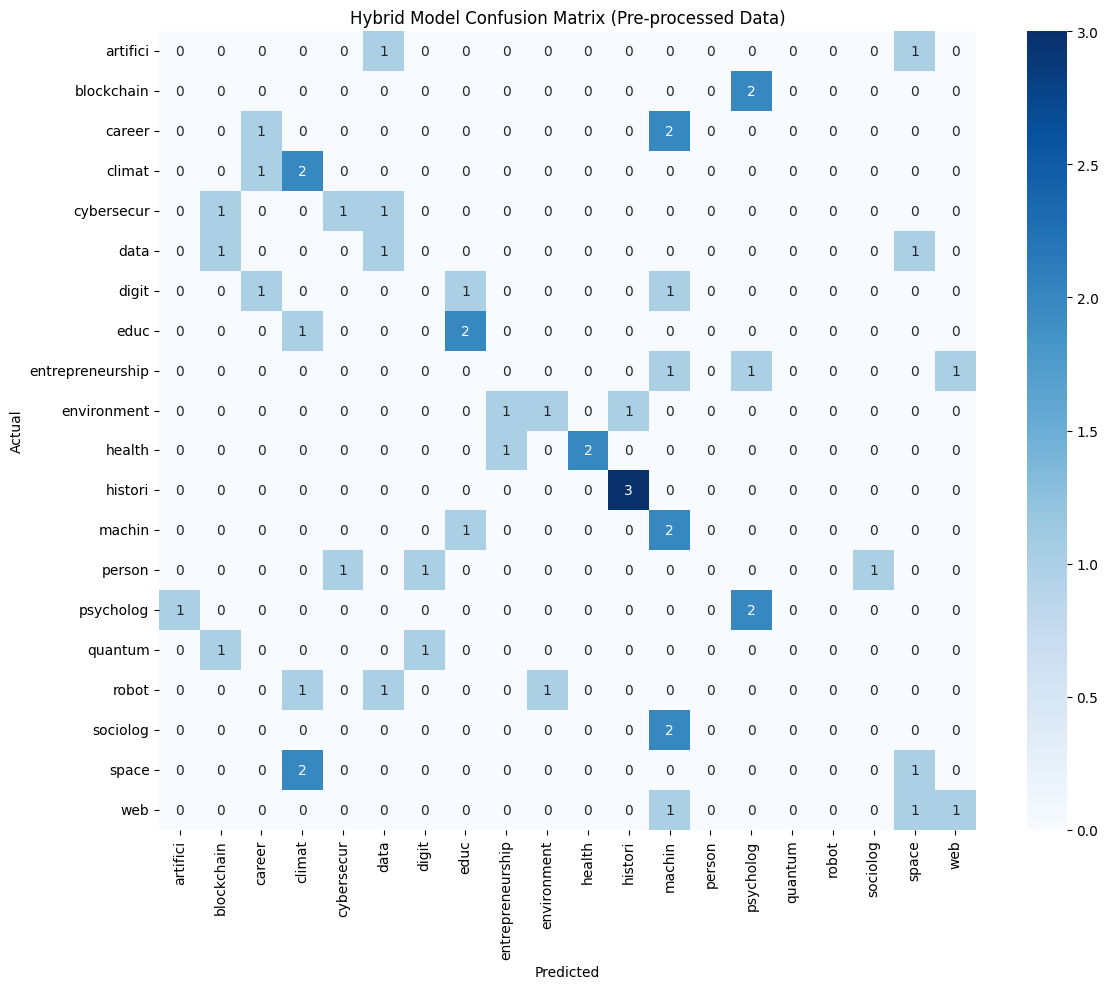

In [ ]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    MobileBertTokenizer, MobileBertForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
# Taking only the first topic for single-label classification
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') and len(ast.literal_eval(x)) > 0 else None)
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

# Step 5: Handle Class Imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
df_balanced = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Step 6: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)

# Step 7: Create PyTorch Datasets
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Tokenizers
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
mobilebert_tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

train_encodings_db = tokenize(train_df['text'], distilbert_tokenizer)
val_encodings_db = tokenize(val_df['text'], distilbert_tokenizer)
train_encodings_mb = tokenize(train_df['text'], mobilebert_tokenizer)
val_encodings_mb = tokenize(val_df['text'], mobilebert_tokenizer)

train_dataset_db = TopicDataset(train_encodings_db, train_df['label'].values)
val_dataset_db = TopicDataset(val_encodings_db, val_df['label'].values)
train_dataset_mb = TopicDataset(train_encodings_mb, train_df['label'].values)
val_dataset_mb = TopicDataset(val_encodings_mb, val_df['label'].values)

# --- Train Model 1: DistilBERT ---
print("--- Training DistilBERT Model ---")
model_db = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
training_args_db = TrainingArguments(
    output_dir='./ensemble/distilbert_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_db = Trainer(model=model_db, args=training_args_db, train_dataset=train_dataset_db)
trainer_db.train()

# --- Train Model 2: MobileBERT ---
print("\n--- Training MobileBERT Model ---")
model_mb = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=num_labels)
training_args_mb = TrainingArguments(
    output_dir='./ensemble/mobilebert_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_mb = Trainer(model=model_mb, args=training_args_mb, train_dataset=train_dataset_mb)
trainer_mb.train()
print("\n" + "="*50 + "\n")

# --- Step 8: Ensemble Predictions and Evaluate ---
print("--- Evaluating Hybrid (DistilBERT + MobileBERT) Model ---")
preds_db = trainer_db.predict(val_dataset_db)
preds_mb = trainer_mb.predict(val_dataset_mb)

# Convert logits to probabilities and average them
probs_db = torch.softmax(torch.from_numpy(preds_db.predictions), dim=1).numpy()
probs_mb = torch.softmax(torch.from_numpy(preds_mb.predictions), dim=1).numpy()
avg_probs = (probs_db + probs_mb) / 2

# Use argmax to get the single best prediction from the averaged probabilities
y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_df['label'].values

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Hybrid Model Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_hybrid_preprocessed.png")
print("Hybrid confusion matrix saved as confusion_matrix_hybrid_preprocessed.png")
print("\n" + "="*50 + "\n")

# --- Step 9: Inference with Hybrid Model ---
print("--- Hybrid Model Inference Example ---")
test_text = "marriag best film dream wish"

inputs_db = tokenize([test_text], distilbert_tokenizer)
inputs_mb = tokenize([test_text], mobilebert_tokenizer)

device = trainer_db.args.device
inputs_db = {k: v.to(device) for k, v in inputs_db.items()}
inputs_mb = {k: v.to(device) for k, v in inputs_mb.items()}

model_db.eval()
model_mb.eval()
with torch.no_grad():
    logits_db = model_db(**inputs_db).logits
    logits_mb = model_mb(**inputs_mb).logits

    probs_db_inf = torch.softmax(logits_db, dim=1)
    probs_mb_inf = torch.softmax(logits_mb, dim=1)

    avg_probs_inf = (probs_db_inf + probs_mb_inf) / 2

    pred_label = avg_probs_inf.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]

    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (200, 2)




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Training DistilBERT Model ---


Step,Training Loss
20,3.004300
40,3.001000
60,2.984800
80,2.941000
100,2.900500
120,2.799600
140,2.744400
160,2.609900
180,2.557700
200,2.482900



--- Training MobileBERT Model ---


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,5773814.000000
40,38795.118800
60,3.459200
80,3.135000
100,2.962100
120,2.921600
140,2.701800
160,2.579200
180,2.567700
200,2.378500




--- Evaluating Hybrid (DistilBERT + MobileBERT) Model ---



Hybrid Model Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       0.33      0.33      0.33         3
          climat       0.29      0.67      0.40         3
      cybersecur       1.00      0.33      0.50         3
            data       0.33      0.33      0.33         3
           digit       0.00      0.00      0.00         3
            educ       0.50      0.67      0.57         3
entrepreneurship       0.00      0.00      0.00         3
     environment       0.50      0.33      0.40         3
          health       1.00      0.67      0.80         3
         histori       0.75      1.00      0.86         3
          machin       0.25      0.67      0.36         3
          person       0.00      0.00      0.00         3
       psycholog       0.40      0.67      0.50         3
         quantum       0.00      

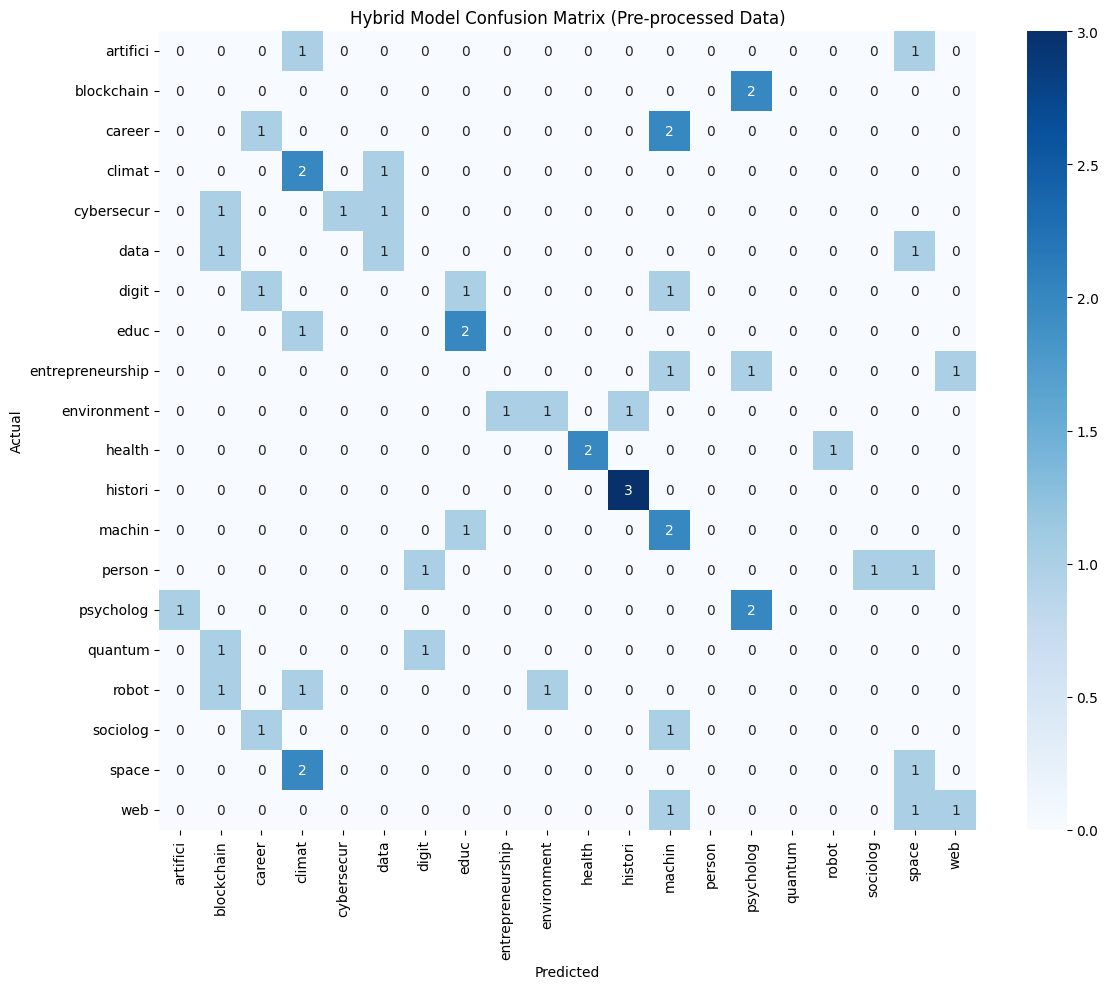

In [ ]:
# Approach 3
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    MobileBertTokenizer, MobileBertForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
# Taking only the first topic for single-label classification
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') and len(ast.literal_eval(x)) > 0 else None)
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

# Step 5: Handle Class Imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
df_balanced = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Step 6: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)

# Step 7: Create PyTorch Datasets
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Tokenizers
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
mobilebert_tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

train_encodings_db = tokenize(train_df['text'], distilbert_tokenizer)
val_encodings_db = tokenize(val_df['text'], distilbert_tokenizer)
train_encodings_mb = tokenize(train_df['text'], mobilebert_tokenizer)
val_encodings_mb = tokenize(val_df['text'], mobilebert_tokenizer)

train_dataset_db = TopicDataset(train_encodings_db, train_df['label'].values)
val_dataset_db = TopicDataset(val_encodings_db, val_df['label'].values)
train_dataset_mb = TopicDataset(train_encodings_mb, train_df['label'].values)
val_dataset_mb = TopicDataset(val_encodings_mb, val_df['label'].values)

# --- Train Model 1: DistilBERT ---
print("--- Training DistilBERT Model ---")
model_db = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
training_args_db = TrainingArguments(
    output_dir='./ensemble/distilbert_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_db = Trainer(model=model_db, args=training_args_db, train_dataset=train_dataset_db)
trainer_db.train()

# --- Train Model 2: MobileBERT ---
print("\n--- Training MobileBERT Model ---")
model_mb = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=num_labels)
training_args_mb = TrainingArguments(
    output_dir='./ensemble/mobilebert_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_mb = Trainer(model=model_mb, args=training_args_mb, train_dataset=train_dataset_mb)
trainer_mb.train()
print("\n" + "="*50 + "\n")

# --- Step 8: Ensemble Predictions and Evaluate ---
print("--- Evaluating Hybrid (DistilBERT + MobileBERT) Model ---")
preds_db = trainer_db.predict(val_dataset_db)
preds_mb = trainer_mb.predict(val_dataset_mb)

# Convert logits to probabilities and average them
probs_db = torch.softmax(torch.from_numpy(preds_db.predictions), dim=1).numpy()
probs_mb = torch.softmax(torch.from_numpy(preds_mb.predictions), dim=1).numpy()
avg_probs = (probs_db + probs_mb) / 2

# Use argmax to get the single best prediction
y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_df['label'].values

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Hybrid Model Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_hybrid_preprocessed.png")
print("Hybrid confusion matrix saved as confusion_matrix_hybrid_preprocessed.png")
print("\n" + "="*50 + "\n")

# --- Step 9: Inference with Hybrid Model ---
print("--- Hybrid Model Inference Example ---")
test_text = "marriag best film dream wish"

inputs_db = tokenize([test_text], distilbert_tokenizer)
inputs_mb = tokenize([test_text], mobilebert_tokenizer)

device = trainer_db.args.device
inputs_db = {k: v.to(device) for k, v in inputs_db.items()}
inputs_mb = {k: v.to(device) for k, v in inputs_mb.items()}

model_db.eval()
model_mb.eval()
with torch.no_grad():
    logits_db = model_db(**inputs_db).logits
    logits_mb = model_mb(**inputs_mb).logits

    probs_db_inf = torch.softmax(logits_db, dim=1)
    probs_mb_inf = torch.softmax(logits_mb, dim=1)

    avg_probs_inf = (probs_db_inf + probs_mb_inf) / 2

    pred_label = avg_probs_inf.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]

    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")

In [ ]:
# Hybrid DistilBERT + MobileBERT Multi-label Topic Classification

# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    MobileBertTokenizer, MobileBertForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data

df = pd.read_csv("output_part_1.csv")
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic_list'] = df['topic'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [])
df = df[['text', 'topic_list']]
df = df[df['text'] != '']
df = df[df['topic_list'].apply(len) > 0]

print("--- Data Loading and Preparation ---")
print("Data shape after processing:", df.shape)
print("="*50)

# Step 4: Multi-Label Binarization
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df['topic_list'])
num_labels = len(mlb.classes_)
print(f"Found {num_labels} unique topics.")

# Step 5: Train/Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], labels, test_size=0.2, random_state=42
)

# Step 6: PyTorch Dataset
class MultiLabelTopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item
    def __len__(self):
        return len(self.labels)

# Tokenizers
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
mobilebert_tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

train_encodings_db = tokenize(train_texts, distilbert_tokenizer)
val_encodings_db = tokenize(val_texts, distilbert_tokenizer)
train_encodings_mb = tokenize(train_texts, mobilebert_tokenizer)
val_encodings_mb = tokenize(val_texts, mobilebert_tokenizer)

train_dataset_db = MultiLabelTopicDataset(train_encodings_db, train_labels)
val_dataset_db = MultiLabelTopicDataset(val_encodings_db, val_labels)
train_dataset_mb = MultiLabelTopicDataset(train_encodings_mb, train_labels)
val_dataset_mb = MultiLabelTopicDataset(val_encodings_mb, val_labels)

# Step 7: Train DistilBERT
print("--- Training DistilBERT ---")
model_db = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=num_labels, problem_type="multi_label_classification"
)
training_args_db = TrainingArguments(
    output_dir='./ensemble_multi/distilbert_preprocessed',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    report_to=[]
)
trainer_db = Trainer(model=model_db, args=training_args_db, train_dataset=train_dataset_db)
trainer_db.train()

# Step 8: Train MobileBERT
print("--- Training MobileBERT ---")
model_mb = MobileBertForSequenceClassification.from_pretrained(
    'google/mobilebert-uncased', num_labels=num_labels, problem_type="multi_label_classification"
)
training_args_mb = TrainingArguments(
    output_dir='./ensemble_multi/mobilebert_preprocessed',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    report_to=[]
)
trainer_mb = Trainer(model=model_mb, args=training_args_mb, train_dataset=train_dataset_mb)
trainer_mb.train()
print("="*50)

# Step 9: Ensemble Predictions and Threshold Optimization
print("--- Evaluating Hybrid Model ---")
preds_db = trainer_db.predict(val_dataset_db)
preds_mb = trainer_mb.predict(val_dataset_mb)

logits_db = torch.from_numpy(preds_db.predictions)
logits_mb = torch.from_numpy(preds_mb.predictions)
avg_logits = (logits_db + logits_mb) / 2
avg_probs = torch.sigmoid(avg_logits).numpy()
y_true = val_labels

best_f1 = 0
optimal_threshold = 0.5
for threshold in np.arange(0.1, 0.9, 0.05):
    y_pred_temp = (avg_probs > threshold).astype(int)
    f1_micro = f1_score(y_true, y_pred_temp, average='micro', zero_division=0)
    print(f"Threshold: {threshold:.2f}, F1 (micro): {f1_micro:.4f}")
    if f1_micro > best_f1:
        best_f1 = f1_micro
        optimal_threshold = threshold
print(f"\nOptimal Threshold: {optimal_threshold:.2f} (F1-micro: {best_f1:.4f})")
print("="*50)

# Step 10: Final Evaluation
y_pred_ensemble = (avg_probs > optimal_threshold).astype(int)
print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=mlb.classes_, zero_division=0))

# Step 11: Inference Example
print("--- Hybrid Model Inference Example ---")
test_text = "organ choos concern eye stage three point despit senior serv citizen idea u"
inputs_db = tokenize([test_text], distilbert_tokenizer)
inputs_mb = tokenize([test_text], mobilebert_tokenizer)
device = trainer_db.args.device
inputs_db = {k: v.to(device) for k, v in inputs_db.items()}
inputs_mb = {k: v.to(device) for k, v in inputs_mb.items()}
model_db.eval()
model_mb.eval()
with torch.no_grad():
    logits_db = model_db(**inputs_db).logits
    logits_mb = model_mb(**inputs_mb).logits
    avg_logits_inf = (logits_db + logits_mb) / 2
    probs_inf = torch.sigmoid(avg_logits_inf)
    pred_labels_bin = (probs_inf > optimal_threshold).cpu().numpy()
    pred_topics = mlb.inverse_transform(pred_labels_bin)
    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topics: {pred_topics[0] if pred_topics else 'None'}")

--- Data Loading and Preparation ---
Data shape after processing: (200, 2)
Found 30 unique topics.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Training DistilBERT ---


Step,Training Loss


--- Training MobileBERT ---


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


--- Evaluating Hybrid Model ---


Threshold: 0.10, F1 (micro): 0.0794
Threshold: 0.15, F1 (micro): 0.0000
Threshold: 0.20, F1 (micro): 0.0000
Threshold: 0.25, F1 (micro): 0.0000
Threshold: 0.30, F1 (micro): 0.0000
Threshold: 0.35, F1 (micro): 0.0000
Threshold: 0.40, F1 (micro): 0.0000
Threshold: 0.45, F1 (micro): 0.0000
Threshold: 0.50, F1 (micro): 0.0000
Threshold: 0.55, F1 (micro): 0.0000
Threshold: 0.60, F1 (micro): 0.0000
Threshold: 0.65, F1 (micro): 0.0000
Threshold: 0.70, F1 (micro): 0.0000
Threshold: 0.75, F1 (micro): 0.0000
Threshold: 0.80, F1 (micro): 0.0000
Threshold: 0.85, F1 (micro): 0.0000

Optimal Threshold: 0.10 (F1-micro: 0.0794)

Hybrid Model Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       0.00      0.00      0.00         0
           chang       0.00      0.00      0.00         2
          climat       0.00      0.00      0.00    

**Roberta + Albert**

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (200, 2)


--- Training RoBERTa Model ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,2.996900
40,3.019400
60,3.007800
80,3.004200
100,3.009100
120,2.992000
140,2.992000
160,2.977000
180,2.963500
200,2.952400


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Training ALBERT Model ---


Step,Training Loss
20,3.068200
40,3.024700
60,3.086600
80,3.047600
100,3.036200
120,2.986500
140,2.895000
160,2.713800
180,2.586000
200,2.369000




--- Evaluating Hybrid (RoBERTa + ALBERT) Model ---



Hybrid Model Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       1.00      0.33      0.50         3
          climat       0.40      0.67      0.50         3
      cybersecur       0.50      0.33      0.40         3
            data       0.67      0.67      0.67         3
           digit       0.00      0.00      0.00         3
            educ       0.67      0.67      0.67         3
entrepreneurship       0.50      0.33      0.40         3
     environment       0.67      0.67      0.67         3
          health       1.00      0.67      0.80         3
         histori       0.75      1.00      0.86         3
          machin       0.50      0.67      0.57         3
          person       0.50      0.33      0.40         3
       psycholog       0.67      0.67      0.67         3
         quantum       1.00      

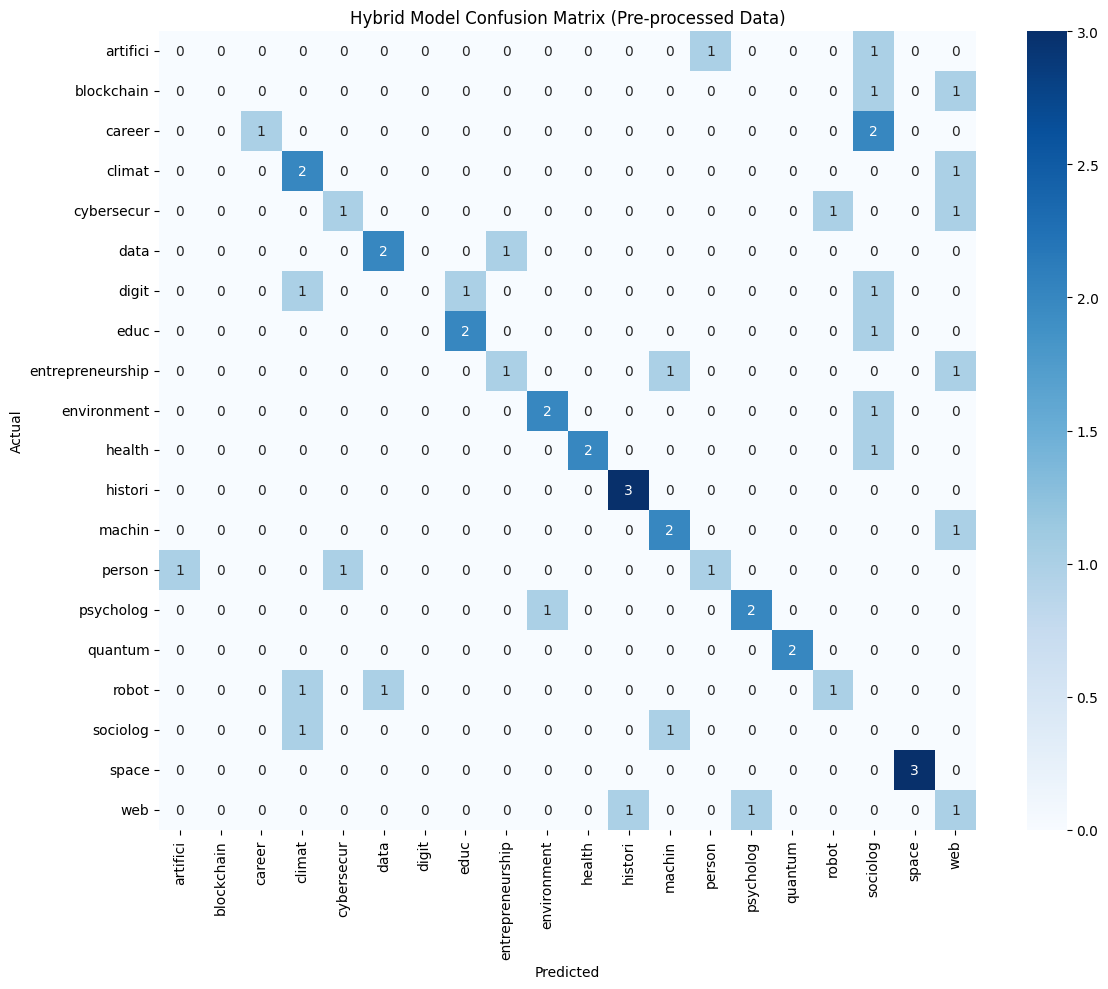

In [ ]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    AlbertTokenizer, AlbertForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') and len(ast.literal_eval(x)) > 0 else None)
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

# Step 5: Handle Class Imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
df_balanced = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Step 6: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)

# Step 7: Create PyTorch Datasets
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Tokenizers
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

train_encodings_rb = tokenize(train_df['text'], roberta_tokenizer)
val_encodings_rb = tokenize(val_df['text'], roberta_tokenizer)
train_encodings_albert = tokenize(train_df['text'], albert_tokenizer)
val_encodings_albert = tokenize(val_df['text'], albert_tokenizer)

train_dataset_rb = TopicDataset(train_encodings_rb, train_df['label'].values)
val_dataset_rb = TopicDataset(val_encodings_rb, val_df['label'].values)
train_dataset_albert = TopicDataset(train_encodings_albert, train_df['label'].values)
val_dataset_albert = TopicDataset(val_encodings_albert, val_df['label'].values)

# --- Train Model 1: RoBERTa ---
print("--- Training RoBERTa Model ---")
model_rb = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
training_args_rb = TrainingArguments(
    output_dir='./ensemble/roberta_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_rb = Trainer(model=model_rb, args=training_args_rb, train_dataset=train_dataset_rb)
trainer_rb.train()

# --- Train Model 2: ALBERT ---
print("\n--- Training ALBERT Model ---")
model_albert = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=num_labels)
training_args_albert = TrainingArguments(
    output_dir='./ensemble/albert_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_albert = Trainer(model=model_albert, args=training_args_albert, train_dataset=train_dataset_albert)
trainer_albert.train()
print("\n" + "="*50 + "\n")

# --- Step 8: Ensemble Predictions and Evaluate ---
print("--- Evaluating Hybrid (RoBERTa + ALBERT) Model ---")
preds_rb = trainer_rb.predict(val_dataset_rb)
preds_albert = trainer_albert.predict(val_dataset_albert)

probs_rb = torch.softmax(torch.from_numpy(preds_rb.predictions), dim=1).numpy()
probs_albert = torch.softmax(torch.from_numpy(preds_albert.predictions), dim=1).numpy()
avg_probs = (probs_rb + probs_albert) / 2

y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_df['label'].values

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Hybrid Model Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_hybrid_preprocessed.png")
print("Hybrid confusion matrix saved as confusion_matrix_hybrid_preprocessed.png")
print("\n" + "="*50 + "\n")

# --- Step 9: Inference with Hybrid Model ---
print("--- Hybrid Model Inference Example ---")
test_text = "marriag best film dream wish"

inputs_rb = tokenize([test_text], roberta_tokenizer)
inputs_albert = tokenize([test_text], albert_tokenizer)

device = trainer_rb.args.device
inputs_rb = {k: v.to(device) for k, v in inputs_rb.items()}
inputs_albert = {k: v.to(device) for k, v in inputs_albert.items()}

model_rb.eval()
model_albert.eval()
with torch.no_grad():
    logits_rb = model_rb(**inputs_rb).logits
    logits_albert = model_albert(**inputs_albert).logits

    probs_rb_inf = torch.softmax(logits_rb, dim=1)
    probs_albert = torch.softmax(logits_albert, dim=1)

    avg_probs_inf = (probs_rb_inf + probs_albert) / 2

    pred_label = avg_probs_inf.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]

    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")